# Chapter 8 機械学習の基礎（教師あり学習）

# 8-1 機械学習の全体像

## 8-1-1 機械学習とは

### 1-1 教師あり学習と教師なし学習

### 1-2 強化学習

### 1-3 機械学習を適用するにあたって

## 8-1-2 教師あり学習

### 2-1 教師あり学習の手法

## 8-1-3 教師なし学習

### 3-1 教師なし学習の手法

## 8-1-4 強化学習

### 4-1 強化学習の手法

## 8-1-5 この章で使用するライブラリのインポート

In [34]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

%precision 3

'%.3f'

# 8-2 重回帰

## 8-2-1 自動車価格データの取り込み

In [35]:
import requests, zipfile
import io

# 自動車価格データを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
auto = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# データの列にラベルを設定
auto.columns=['symboling', 'normalized-loss', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
			  'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
			  'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore',
			  'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [36]:
print('自動車データの形式:{}'.format(auto.shape))

自動車データの形式:(205, 26)


In [37]:
auto.head()

,symboling,normalized-loss,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## 8-2-2 データの整理
### 2-1 不適切なデータの除去

In [38]:
# それぞれのカラムに ? がいくつあるかカウント
auto1 = auto[['price', 'horsepower', 'width', 'height']]
auto1.isin(['?']).sum()

price         4
horsepower    2
width         0
height        0
dtype: int64

In [39]:
# ? をNaNに置き換えて、NaNがある行を削除
auto1 = auto1.replace('?', np.nan).dropna()
print('自動車データの形式:{}'.format(auto1.shape))

自動車データの形式:(199, 4)


### 2-2 型の変換

In [40]:
print('データ型の確認（型変換前）\n{}\n'.format(auto1.dtypes))

データ型の確認（型変換前）
price          object
horsepower     object
width         float64
height        float64
dtype: object



In [41]:
# objectをnumericに変換！
auto1 = auto1.assign(price=pd.to_numeric(auto1.price))
auto1 = auto1.assign(horsepower=pd.to_numeric(auto1.horsepower))
print('データ型の確認（型変換後）\n{}\n'.format(auto1.dtypes))

データ型の確認（型変換後）
price           int64
horsepower      int64
width         float64
height        float64
dtype: object



### 2-3 相関の確認

In [42]:
# 相関係数を確認。
# priceが今回の目的変数
auto1.corr()

,price,horsepower,width,height
price,1.000000,0.810533,0.753871,0.134990
horsepower,0.810533,1.000000,0.615315,-0.087407
width,0.753871,0.615315,1.000000,0.309223
height,0.134990,-0.087407,0.309223,1.000000


price(目的変数)以外に着目すると、widthとhorsepowerの相関が0.6とやや高め。実務では多重共線性が生じる可能性があるので、重回帰モデル構築においては、総監の高い変数軍からは代表の変数しか使用しない。（ここでは気にしていないが）

## 8-2-3 モデル構築と評価

In [43]:
# データ分割のためのインポート
from sklearn.model_selection import train_test_split

# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression

# 目的変数にpriceを指定、説明変数にそれ以外を指定
X = auto1.drop('price', axis=1)
y = auto1['price']

# 訓練データとテストデータを分ける
# random_stateを任意の値を固定して再現性を持たせる
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 重回帰クラスの初期化と学習
# インスタンスの生成
model = LinearRegression()
# 学習実行
model.fit(X_train, y_train)

# 決定係数を表示（score メソッドで取得できる）
print('決定係数(train): {:.3f}'.format(model.score(X_train, y_train)))
print('決定係数(test): {:.3f}'.format(model.score(X_test, y_test)))

# 回帰係数と切片を表示
print('\n回帰係数\n{}'.format(pd.Series(model.coef_, index=X.columns)))
print('切片: {:.3f}'.format(model.intercept_))

決定係数(train): 0.733
決定係数(test): 0.737

回帰係数
horsepower      81.651078
width         1829.174506
height         229.510077
dtype: float64
切片: -128409.046


## 8-2-4 モデル構築とモデル評価の流れのまとめ

### 練習問題 8-1

In [44]:
auto.head()

,symboling,normalized-loss,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [45]:
auto2 = auto[['price', 'width', 'engine-size']]
auto2 = auto2.replace('?', np.nan).dropna()
auto2 = auto2.assign(price=pd.to_numeric(auto2.price))
# auto2.isnull().sum()
auto2.isin(['?']).sum()

price          0
width          0
engine-size    0
dtype: int64

In [46]:
# データ分割のためのインポート
from sklearn.model_selection import train_test_split

# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression

# 目的変数にpriceを指定、説明変数にそれ以外を指定
X = auto2.drop('price', axis=1)
y = auto2['price']

# 訓練データとテストデータを分ける
# random_stateを任意の値を固定して再現性を持たせる
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 重回帰クラスの初期化と学習
# インスタンスの生成
model = LinearRegression()
# 学習実行
model.fit(X_train, y_train)

# 決定係数を表示（score メソッドで取得できる）
print('決定係数(train): {:.3f}'.format(model.score(X_train, y_train)))
print('決定係数(test): {:.3f}'.format(model.score(X_test, y_test)))

# 回帰係数と切片を表示
print('\n回帰係数\n{}'.format(pd.Series(model.coef_, index=X.columns)))
print('切片: {:.3f}'.format(model.intercept_))

決定係数(train): 0.783
決定係数(test): 0.778

回帰係数
width          1261.735518
engine-size     109.526787
dtype: float64
切片: -84060.643


# 8-3 ロジスティック回帰
## 8-3-1 ロジスティック回帰の例

In [50]:
# データを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
adult = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# データの列にラベルを設定
adult.columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'flg-50K']

# データの形式と欠損値を出力
print('データの形式:{}'.format(adult.shape))
print('欠損の数:{}'.format(adult.isnull().sum().sum()))

# データの先頭5行の出力
adult.head()


データの形式:(32561, 15)
欠損の数:0


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,flg-50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 8-3-2 データの整理

In [51]:
adult.groupby('flg-50K').size()

flg-50K
<=50K    24720
>50K      7841
dtype: int64

In [52]:
# fin_flgというカラムを追加し、もし「flg-50K」のカラムの値が「>50K」だったら1、そうでなければ0をセットする
adult['fin_flg'] = adult['flg-50K'].map(lambda x: 1 if x == ' >50K' else 0)
adult.groupby('fin_flg').size()

fin_flg
0    24720
1     7841
dtype: int64

## 8-3-3 モデル構築と評価

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 説明変数と目的変数の設定
X = adult[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']]
y = adult['fin_flg']

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# ロジスティック回帰クラスの初期化と学習
model = LogisticRegression()
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.796
正解率(test):0.799


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
model.coef_

array([[-5.624e-03, -3.846e-06, -3.642e-02,  3.286e-04,  7.666e-04]])

In [55]:
np.exp(model.coef_)

array([[0.994, 1.   , 0.964, 1.   , 1.001]])

## 8-3-4 スケーリングによる予測精度の向上

値が大きな変数に引っ張られないための標準化！

In [56]:
# 標準化のためのクラスをインポート
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 説明変数と目的変数の設定
X = adult[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']]
y = adult['fin_flg']

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 標準化処理（先ほどから追加した部分）
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# ロジスティック回帰クラスの初期化と学習
model = LogisticRegression()
model.fit(X_train_std, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test_std, y_test)))

正解率(train):0.811
正解率(test):0.810


### 練習問題 8-2 （標準化なしロジスティック回帰）

In [57]:
# データセットのインポート
from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# データセットのロード
cancer = load_breast_cancer()

# 説明変数と目的変数の設定
X = cancer.data
y = cancer.target

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


# ロジスティック回帰クラスの初期化と学習
model = LogisticRegression()
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))


正解率(train):0.968
正解率(test):0.954


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 練習問題 8-3（標準化ありロジスティック回帰）

In [58]:
# データセットのインポート
from sklearn.datasets import load_breast_cancer
# 標準化のためのクラスをインポート
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# データセットのロード
cancer = load_breast_cancer()

# 説明変数と目的変数の設定
X = cancer.data
y = cancer.target

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# ロジスティック回帰クラスの初期化と学習
model = LogisticRegression()
model.fit(X_train_std, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test_std, y_test)))


正解率(train):0.989
正解率(test):0.975


# 8-4 正則化項のある回帰：ラッソ回帰、リッジ回帰

## 8-4-1 ラッソ回帰、リッジ回帰

## 8-4-2 重回帰とリッジ回帰の比較

In [59]:
auto.head()

,symboling,normalized-loss,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [60]:
# リッジ回帰用のクラス
from sklearn.linear_model import Ridge

# 目的変数にpriceを指定、説明変数にそれ以外を指定
X = auto1.drop('price', axis=1)
y = auto1['price']

# 訓練データとテストデータを分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# モデルの構築と評価
linear = LinearRegression()
ridge = Ridge(random_state=0)

for model in [linear, ridge]:
	model.fit(X_train, y_train)
	print('{}(train): {:.6f}'.format(model.__class__.__name__, model.score(X_train, y_train)))
	print('{}(test): {:.6f}'.format(model.__class__.__name__, model.score(X_test, y_test)))

LinearRegression(train): 0.733358
LinearRegression(test): 0.737069
Ridge(train): 0.733355
Ridge(test): 0.737768


訓練データでは重回帰の正解率が高いが、テストデータで逆転が起きているのは正則化項のおかげ？

# 8-5 決定木
## 8-5-1 きのこデータセット

In [61]:
# データを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# データの列にラベルを設定
mushroom.columns=['classes', 'cap_shape', 'cap_surface', 'cap_color', 'odor', 'bruises', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_above_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']

# データの形式と欠損値を出力
print('データの形式:{}'.format(mushroom.shape))
print('欠損の数:{}'.format(mushroom.isnull().sum().sum()))

# データの先頭5行の出力
mushroom.head()


データの形式:(8124, 23)
欠損の数:0


,classes,cap_shape,cap_surface,cap_color,odor,bruises,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_above_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 8-5-2 データの整理

In [62]:
# カテゴリ変数をget_dummiesでone-hotエンコーディング（ダミー化）する
mushroom_dummy = pd.get_dummies(mushroom[['gill_color', 'gill_attachment', 'odor', 'cap_color']])
mushroom_dummy.head()

,gill_color_b,gill_color_e,gill_color_g,gill_color_h,gill_color_k,gill_color_n,gill_color_o,gill_color_p,gill_color_r,gill_color_u,...,cap_color_b,cap_color_c,cap_color_e,cap_color_g,cap_color_n,cap_color_p,cap_color_r,cap_color_u,cap_color_w,cap_color_y
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [63]:
# 目的変数もフラグ化（0/1化）する
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x: 1 if x == 'p' else 0)

## 8-5-3 エントロピー：不純度の指標

In [64]:
# cap_color_cがどのくらい影響度があるのか、クロス集計してみる
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
False,4176,3904
True,32,12


In [65]:
# cap_color_bがどのくらい影響度があるのか、クロス集計してみる
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
False,4208.0,2188.0
True,NaN,1728.0


In [66]:
# ある条件分岐によって毒キノコの確率が0.5, 0.5になった場合
# エントロピー最大（1）となる
- (0.5 * np.log2(0.5) + 0.5 * np.log2(0.5))

1.000

In [67]:
# ある条件分岐によって毒キノコでない確率が0.001, 毒キノコの可能性が0.999になった場合
# エントロピーが小さく（0に近く）なる
- (0.001 * np.log2(0.001) + 0.999 * np.log2(0.999))

0.011

In [68]:
def calc_entropy(p):
	return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

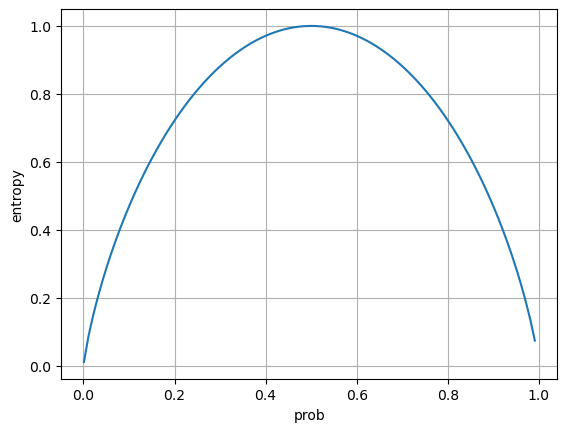

In [69]:
# エントロピーをグラフで表す
# pの値を0.001から0.999まで0.1刻みで動かす
p = np.arange(0.001, 0.999, 0.01)

# グラフ化
plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

In [70]:
mushroom_dummy.groupby('flg')['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

In [71]:
entropy_init = calc_entropy(0.518)
entropy_init

0.999

## 8-5-4 情報利得：分岐条件の有益さを測る

In [72]:
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
False,4176,3904
True,32,12


In [73]:
# cap_colorがcでない場合のエントロピー
entropy_c0 = calc_entropy(4276 / (4176 + 3904))
print(entropy_c0)

0.9975370642373746


In [74]:
# cap_colorがcである場合のエントロピー
entropy_c1 = calc_entropy(32 / (32 + 12))
print(entropy_c1)

0.8453509366224364


In [75]:
# データ分割後の平均エントロピー
entropy_after = (4176 + 3904) / 8124 * entropy_c0 + (32 + 12) / 8124 * entropy_c1
print(entropy_after)

0.9967128163773232


In [76]:
print('変数cap_colorの分割によって得られる情報利得:{:.3f}'.format(entropy_init - entropy_after))

変数cap_colorの分割によって得られる情報利得:0.002


In [77]:
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
False,4208.0,2188.0
True,NaN,1728.0


In [78]:
# grill_colorがbでない場合のエントロピー
entropy_b0 = calc_entropy(4208/(4208 + 2188))
print('grill_colorがbでない場合のエントロピー:{:.3f}'.format(entropy_b0))

# grill_colorがbである場合のエントロピー
entropy_b1 = 0
print('grill_colorがbである場合のエントロピー:{:.3f}'.format(entropy_b1))

# 
entropy_after =  (4208 + 2148) / 8124  * entropy_b0 + (0 + 1728) / 8124 *  entropy_b1
print('変数gill_colorの分割によって得られる情報利得:{:.3f}'.format(entropy_init - entropy_after))

grill_colorがbでない場合のエントロピー:0.927
grill_colorがbである場合のエントロピー:0.000
変数gill_colorの分割によって得られる情報利得:0.274


## 8-5-5 決定木のモデル構築

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# データの分割
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 決定木クラスの初期化と学習
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.909
正解率(test):0.916


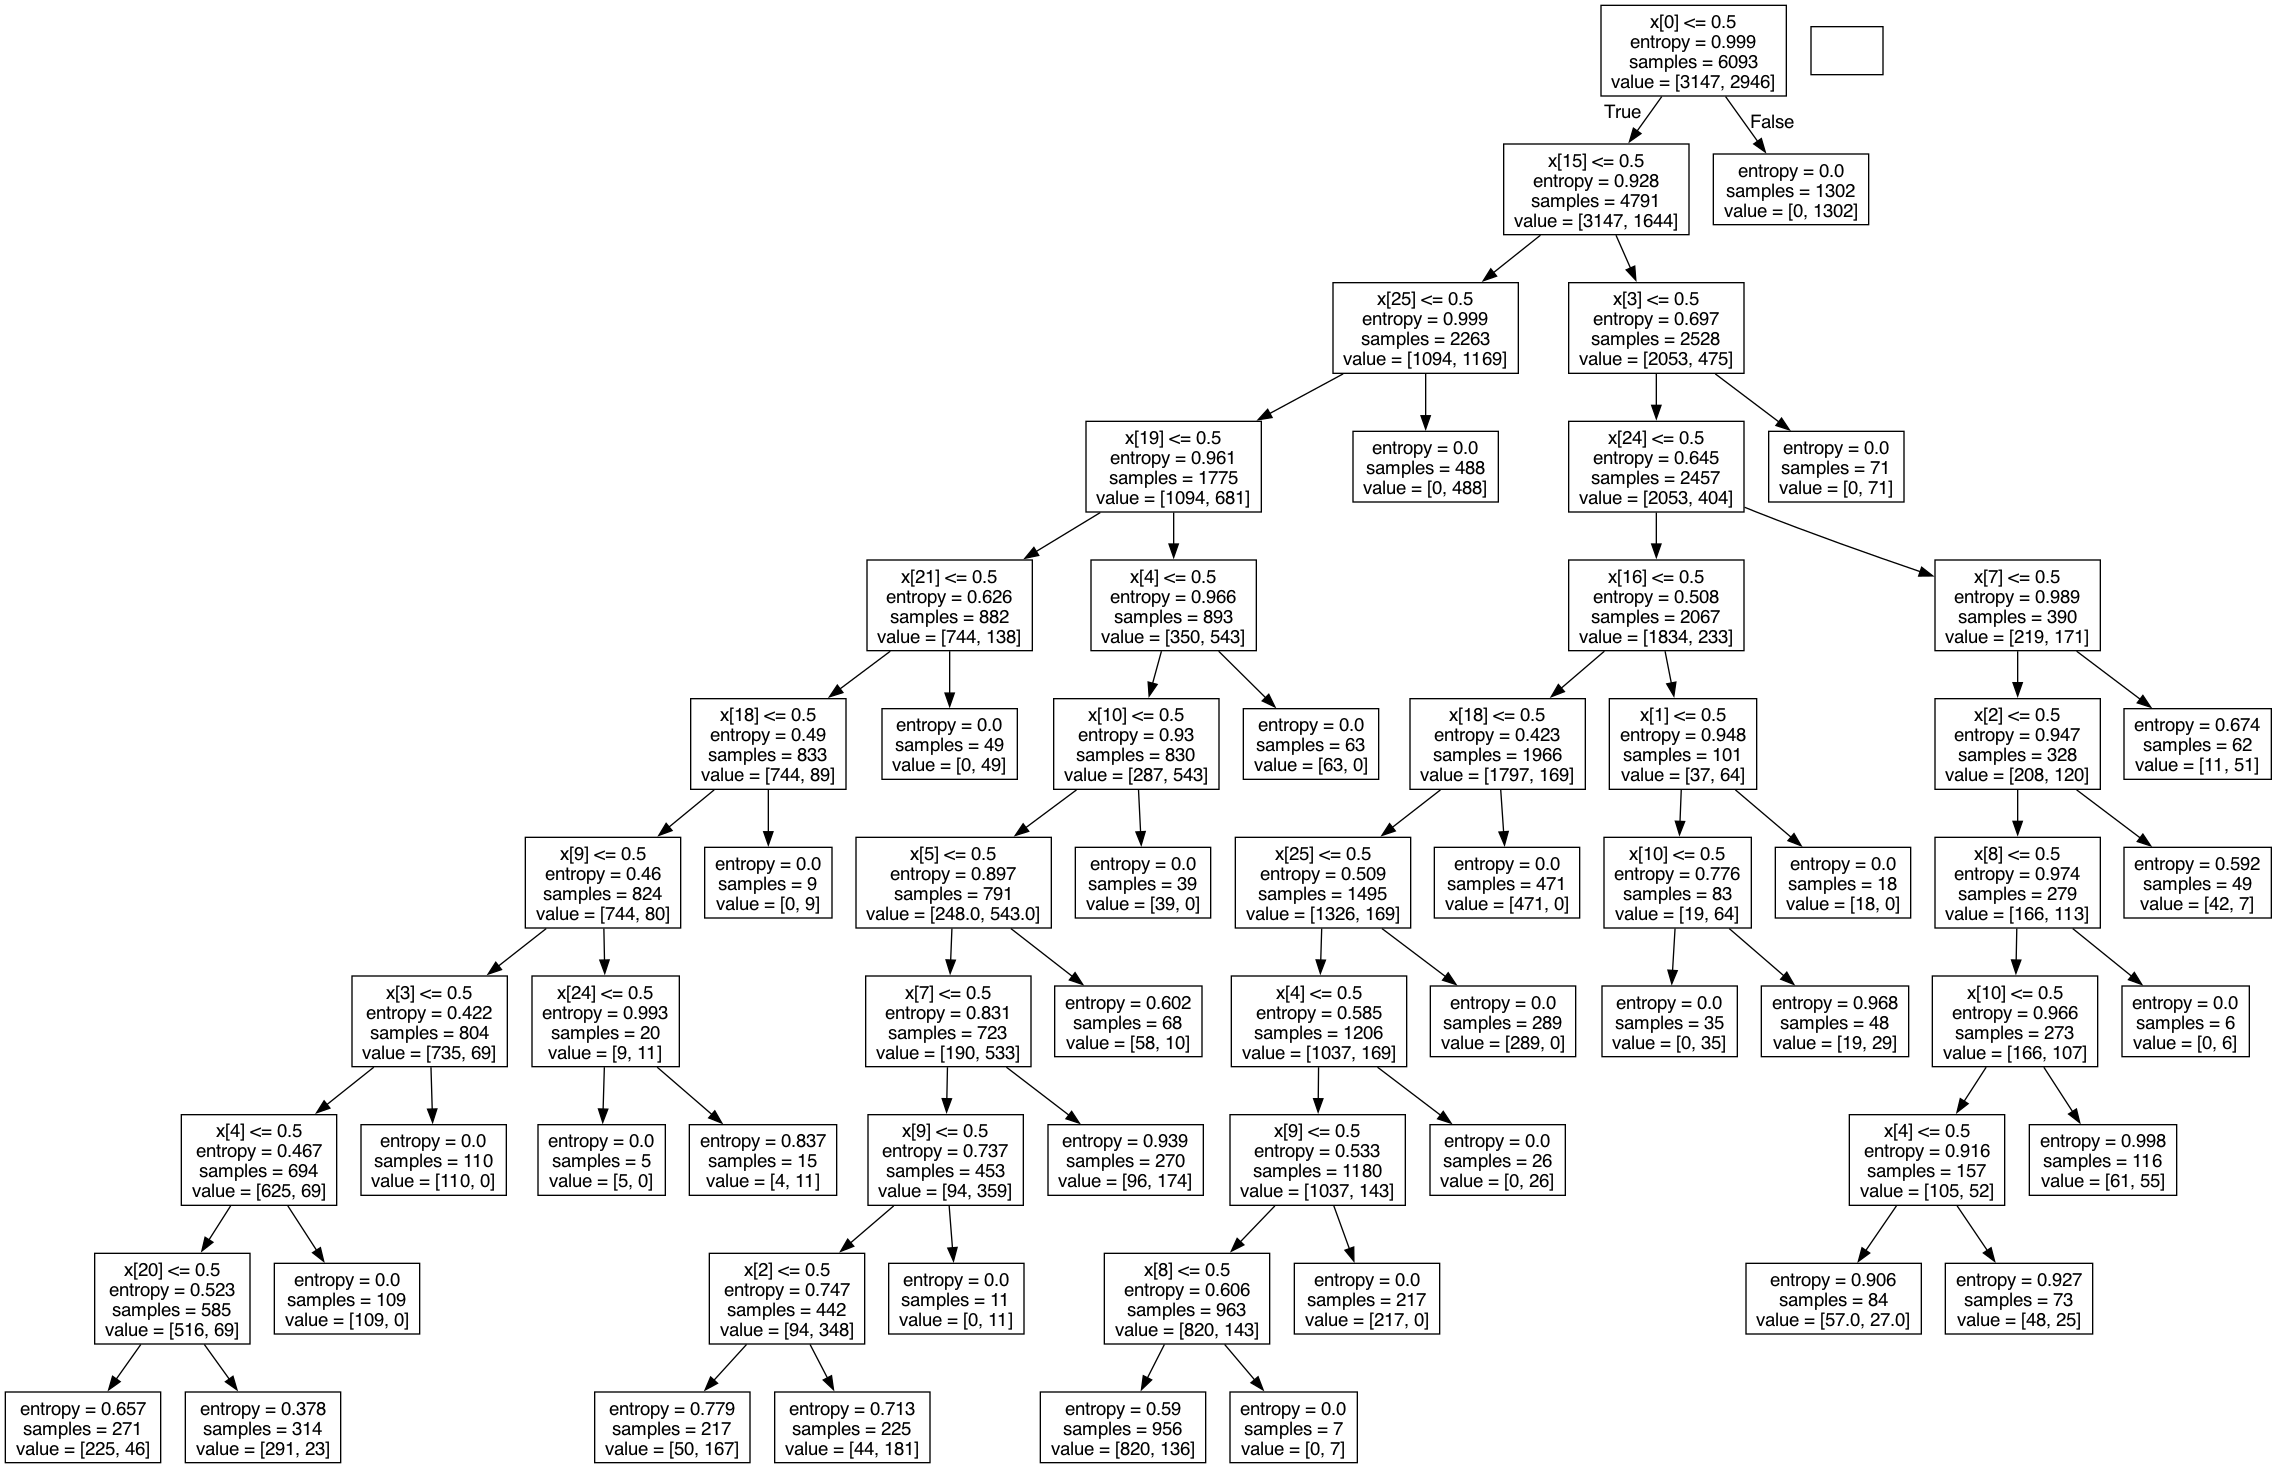

In [80]:
# 参考プログラム
# pydotplusやgraphvizをインストールする必要があります
from sklearn import tree
import pydotplus
from io import StringIO
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### 練習問題 8-5

In [81]:
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# 乳がんデータセットの読み込み
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# データセットを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 評価する木の深さのリスト
depth_values = [1, 3, 5, 10]

# 結果を格納する辞書
results = {
    'Depth': [],
    'Train Score': [],
    'Test Score': []
}

# 異なる深さでモデルを訓練および評価
for depth in depth_values:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    
    results['Depth'].append(depth)
    results['Train Score'].append(train_score)
    results['Test Score'].append(test_score)

# 結果をデータフレームに変換
results_df = pd.DataFrame(results)

# 結果の表示
print(results_df)


   Depth  Train Score  Test Score
0      1     0.920879    0.894737
1      3     0.978022    0.947368
2      5     0.995604    0.947368
3     10     1.000000    0.947368


# 8-6 k-NN（k近傍法）
## 8-6-1 k-NNのモデル構築

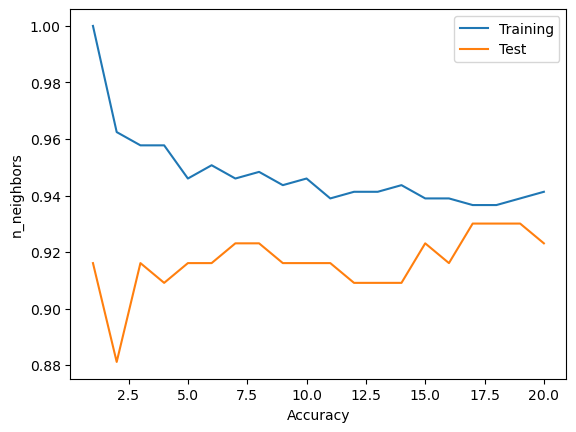

In [82]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# stratifyは層化別抽出
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# グラフ描画用のリストを用意
training_accuracy = []
test_accuracy = []

# 学習
for n_neighbors in range(1,21):
	model = KNeighborsClassifier(n_neighbors=n_neighbors)
	model.fit(X_train, y_train)
	# append()でリストに追加していく
	training_accuracy.append(model.score(X_train, y_train))
	test_accuracy.append(model.score(X_test, y_test))

# グラフを描画
plt.plot(range(1, 21), training_accuracy, label='Training')
plt.plot(range(1, 21), test_accuracy, label='Test')
plt.xlabel('Accuracy')
plt.ylabel('n_neighbors')
plt.legend()

### 練習問題8-6

きのこデータに対してk-NNを使ってモデル構築をしてみる

In [83]:
import pandas as pd
import numpy as np
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# データを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# データの列にラベルを設定
mushroom.columns=['classes', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']

# データの形式と欠損値を出力
print('データの形式:{}'.format(mushroom.shape))
print('欠損の数:{}'.format(mushroom.isnull().sum().sum()))

# データの先頭5行の出力
print(mushroom.head())

# ラベルエンコーディング
label_encoders = {}
for column in mushroom.columns:
    label_encoders[column] = LabelEncoder()
    mushroom[column] = label_encoders[column].fit_transform(mushroom[column])

# 特徴量とラベルに分割
X = mushroom.drop('classes', axis=1)
y = mushroom['classes']

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# k-NNモデルの構築と検証
k_values = [1, 3, 5, 7, 9, 11]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((k, accuracy))
    print(f'k={k}, Accuracy={accuracy}')

# 結果をデータフレームにして表示
results_df = pd.DataFrame(results, columns=['k', 'Accuracy'])
print(results_df)


データの形式:(8124, 23)
欠損の数:0
  classes cap_shape cap_surface cap_color bruises odor gill_attachment  \
0       p         x           s         n       t    p               f   
1       e         x           s         y       t    a               f   
2       e         b           s         w       t    l               f   
3       p         x           y         w       t    p               f   
4       e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color  ... stalk_surface_below_ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk_color_above_ring stalk_color_below_ring veil_type veil_color  \
0                      w                   

### 練習問題8-7

In [84]:
import requests
import zipfile
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# データがあるURLの指定
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00356/student.zip'

# データをURLから取得する
r = requests.get(url, stream=True)

# ZIPファイルを読み書きする
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()

# 区切りに;がついているので要注意
student_data_math = pd.read_csv('student-mat.csv', sep=';')

# 説明変数
X = student_data_math.loc[:, ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'absences', 'G1', 'G2']].values
y = student_data_math['G3'].values

# データをトレーニングセットとテストセットに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# k-Neighbors Regressorを使用してモデルを構築する
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

# テストセットを使用して予測する
y_pred = knn.predict(X_test)

# モデルの性能を評価する（平均二乗誤差を使用）
mse = mean_squared_error(y_test, y_pred)
print(f'平均二乗誤差: {mse}')


KeyboardInterrupt: 

# 8-7 サポートベクターマシン
## 8-7-1 サポートベクターマシンのモデル構築

In [ ]:
# SVMのライブラリ
from sklearn.svm import LinearSVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# データの読み込み
cancer = load_breast_cancer()
# 分割
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# クラスの初期化と学習
model = LinearSVC()
model.fit(X_train, y_train)

# 訓練データとテストデータのスコア
print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.932
正解率(test):0.930


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVMでは標準化するとスコアが改善されることがある

In [ ]:
# SVMのライブラリ
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# データの読み込み
cancer = load_breast_cancer()
# 分割
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# クラスの初期化と学習
model = LinearSVC()
model.fit(X_train_std, y_train)

# 訓練データとテストデータのスコア
print('正解率(train):{:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test_std, y_test)))

正解率(train):0.993
正解率(test):0.951


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### 練習問題8-8

In [ ]:
# SVMのライブラリ
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# データの読み込み
cancer = load_breast_cancer()
# 分割
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# クラスの初期化と学習
# rbfカーネル：非線形なデータにも対応可能！
# Cパラメータ：大きければ誤分類を減らすことに集中し、小さければより柔軟な境界になる
model = SVC(kernel='rbf', random_state=0, C=2)
model.fit(X_train_std, y_train)

# 訓練データとテストデータのスコア
print('正解率(train):{:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test_std, y_test)))

正解率(train):0.995
正解率(test):0.958


## 8章総合問題
### 総合問題 8-1 教師あり学習の用語

### 回帰 (Regression)
- **意味**: 連続的な値を予測するための手法。例えば、家の価格や気温の予測など。
- **役割**: 独立変数と従属変数の関係をモデル化し、数値を予測する。

### 分類 (Classification)
- **意味**: データをカテゴリーに分けるための手法。例えば、メールのスパム判定や画像の分類など。
- **役割**: データを事前定義されたクラスまたはラベルに分類する。

### 教師あり学習 (Supervised Learning)
- **意味**: ラベル付きデータを使ってモデルを訓練し、新しいデータに対する予測を行う機械学習の手法。
- **役割**: 入力データと対応する正解ラベルを用いて、モデルが正確に予測できるように学習する。

### 重回帰分析 (Multiple Regression)
- **意味**: 複数の独立変数を用いて、従属変数を予測する回帰手法。
- **役割**: 独立変数の影響を同時に考慮し、より正確な予測を行う。

### ロジスティック回帰分析 (Logistic Regression)
- **意味**: 分類問題における回帰分析手法。出力は確率値で、通常は0または1に分類される。
- **役割**: 二値分類問題に使用され、特定の事象が発生する確率を予測する。

### 正則化 (Regularization)
- **意味**: モデルの過学習を防ぐために、モデルの複雑さにペナルティを課す手法。
- **役割**: モデルが訓練データに過剰に適合するのを防ぎ、汎化性能を向上させる。

### リッジ回帰 (Ridge Regression)
- **意味**: L2正則化を用いた回帰手法。重みの二乗和にペナルティを加える。
- **役割**: 重みが大きくなるのを防ぎ、過学習を抑制する。

### ラッソ回帰 (Lasso Regression)
- **意味**: L1正則化を用いた回帰手法。重みの絶対値の和にペナルティを加える。
- **役割**: 不要な特徴量の重みをゼロにし、特徴量選択を行う。

### 決定木 (Decision Tree)
- **意味**: データを分割しながら意思決定を行うツリー構造のモデル。
- **役割**: 分類や回帰の問題に使用され、データを特徴に基づいて分割することで予測を行う。

### エントロピー (Entropy)
- **意味**: データの不確実性や混乱度を測る指標。情報理論に基づく。
- **役割**: 決定木の分割基準として使用され、情報の純度を評価する。

### 情報利得 (Information Gain)
- **意味**: データを分割することによって得られる情報の増加量。
- **役割**: 決定木の最適な分割を決定するために使用される。

### k-NN法 (k-Nearest Neighbors)
- **意味**: 新しいデータポイントを最も近いk個の訓練データポイントの多数決で分類する手法。
- **役割**: 距離ベースで分類や回帰を行う、シンプルで直感的なアルゴリズム。

### SVM (Support Vector Machine)
- **意味**: データポイントを分離する最適なハイパープレーンを見つける機械学習アルゴリズム。
- **役割**: 線形または非線形の分類や回帰に使用され、高次元でも効果的に動作する。

### ノーフリーランチ (No Free Lunch)
- **意味**: すべての機械学習アルゴリズムがあらゆる問題で同じように優れているわけではないという定理。
- **役割**: 特定の問題に対して最適なアルゴリズムは存在しないため、問題に応じて適切なアルゴリズムを選択する必要があることを示す。

### 総合問題 8-2 決定木

sklearn.datasetsモジュールのload_iris関数を使用してアヤメの花のデータセットを読み込み、目的変数をiris.target、説明変数をiris.dataとして決定機のモデルを使用して予測と検証を実施してください

In [85]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# アヤメのデータセットをロード
iris = load_iris()
X = iris.data  # 説明変数
y = iris.target  # 目的変数

# データセットをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 決定木分類器を初期化
clf = DecisionTreeClassifier(random_state=42)

# モデルを訓練
clf.fit(X_train, y_train)

# テストセットを使用して予測
y_pred = clf.predict(X_test)

# 精度を計算
accuracy = accuracy_score(y_test, y_pred)

# 分類レポートを生成
report = classification_report(y_test, y_pred, target_names=iris.target_names)

# 結果を出力
print(f"Accuracy: {accuracy}\n")
print("Classification Report:\n")
print(report)


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### 総合問題 8-3 ノーフリーランチ

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# データの読み込み
cancer = load_breast_cancer()

# データ分割
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# モデルの初期化
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machine': SVC(),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-NN': KNeighborsClassifier()
}

# 各モデルの学習と評価
for name, model in models.items():
    if name == 'Linear Regression':  # 線形回帰は回帰モデルなので、分類タスクには向いていないが、一応試してみる
        model.fit(X_train_std, y_train)
        y_pred_train = (model.predict(X_train_std) > 0.5).astype(int)
        y_pred_test = (model.predict(X_test_std) > 0.5).astype(int)
    else:
        model.fit(X_train_std, y_train)
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    print(f'{name} - 訓練データの正解率: {train_accuracy:.3f}')
    print(f'{name} - テストデータの正解率: {test_accuracy:.3f}\n')


Logistic Regression - 訓練データの正解率: 0.991
Logistic Regression - テストデータの正解率: 0.958

Support Vector Machine - 訓練データの正解率: 0.993
Support Vector Machine - テストデータの正解率: 0.958

Linear Regression - 訓練データの正解率: 0.969
Linear Regression - テストデータの正解率: 0.951

Decision Tree - 訓練データの正解率: 1.000
Decision Tree - テストデータの正解率: 0.916

k-NN - 訓練データの正解率: 0.979
k-NN - テストデータの正解率: 0.951



In [88]:
import requests
import zipfile
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# データがあるURLの指定
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00356/student.zip'

# データをURLから取得する
r = requests.get(url, stream=True)

# ZIPファイルを読み書きする
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()

# 区切りに;がついているので要注意
student_data_math = pd.read_csv('student-mat.csv', sep=';')

# 説明変数
X = student_data_math.loc[:, ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'absences', 'G1', 'G2']].values
y = student_data_math['G3'].values

# データをトレーニングセットとテストセットに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの初期化
models = {
    'k-NN': KNeighborsRegressor(n_neighbors=10),
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
}

# 各モデルの学習と評価
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} - 平均二乗誤差: {mse:.3f}')


k-NN - 平均二乗誤差: 4.138
Linear Regression - 平均二乗誤差: 4.569
Support Vector Machine - 平均二乗誤差: 4.122
Decision Tree - 平均二乗誤差: 5.481
